In [74]:
# Import packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load a dataframe
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [75]:
# === 1. Preprocess data ===

# Features & target
X = df[["sepal length (cm)", "sepal width (cm)", "petal width (cm)"]].values
y = df["petal length (cm)"].values


# Train/Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% of the data reserved for the test set
    random_state=412,   # Fix the random seed for reproducibility
)

In [76]:
# === 2. Define models and hyperparameter grids ===

# Regressors
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models_and_params = {
    "Linear": {
        "model": LinearRegression(),
        "param_grid": {"poly__degree": [1,2,3,4]}
    },
    "Ridge": {
        "model": Ridge(),
        "param_grid": {"poly__degree": [1,2,3,4], 
                       "regressor__alpha": [0.001,0.01,0.1,1,10]}
    },
    "Lasso": {
        "model": Lasso(max_iter=100000),
        "param_grid": {"poly__degree": [1,2,3,4], 
                       "regressor__alpha": [0.001,0.01,0.1,1,10]}
    },
    "ElasticNet": {
        "model": ElasticNet(max_iter=100000),
        "param_grid": {"poly__degree": [1,2,3,4], 
                       "regressor__alpha": [0.001,0.01,0.1,1,10], 
                       "regressor__l1_ratio":[0.1,0.5,0.9]}
    },
    "SVR": {
        "model": SVR(),
        "param_grid": {"poly__degree": [1,2,3,4], 
                       "regressor__C": [0.1,1,10], 
                       "regressor__epsilon": [0.01,0.1]}
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=412),
        "param_grid": {"regressor__max_depth": [3,5,7], 
                       "regressor__min_samples_leaf": [1,2,4]}
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=412),
        "param_grid": {"regressor__n_estimators": [50,100], 
                       "regressor__max_depth": [3,5,7], 
                       "regressor__min_samples_leaf": [1,2,4]}
    }
}

In [ ]:
# === 2. Model training, hyperparameter tuning, and evaluation ===

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Find the best parameters for different models
def evaluate_models(X_train, y_train, X_test, y_test, models_and_params,
                    cv=5, plot=False):
    """
    Train multiple models with their own hyperparameter grids,
    find best parameters using GridSearchCV, evaluate on test set,
    and plot predictions.
    """

    results_list = []

    for name, mp in models_and_params.items():
        model = mp["model"]
        param_grid = mp["param_grid"]

        # Tree models don't need polynomial features
        if "DecisionTree" in name or "RandomForest" in name:
            pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),    # Imputer NaN by mean
                ("regressor", model)
            ])
        else:
            pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),    # Imputer NaN by mean
                ("poly", PolynomialFeatures()),                 # Package for finding the best degree
                ("scaler", StandardScaler()),                   # Standardize features after poly
                ("regressor", model)
            ])

        grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring="r2")
        grid.fit(X_train, y_train)

        y_pred_test = grid.predict(X_test)
        r2_cv = grid.best_score_
        r2_test = r2_score(y_test, y_pred_test)
        r2_diff = r2_cv - r2_test   # Determine overfitting
        mse = mean_squared_error(y_test, y_pred_test)
        best_model = grid.best_estimator_
        print(f"The best model for {name}: {best_model}")

        results_list.append({
            "Model": name,
            "Best Params": grid.best_params_,
            "CV R2": r2_cv,
            "Test R2": r2_test,
            "R2 Diff (CV-Test)": r2_diff,
            "Test MSE": mse
        })

        if plot:
            plt.figure(figsize=(5,4))
            plt.scatter(y_test, y_pred_test, color='blue', alpha=0.7)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel("True values")
            plt.ylabel("Predicted values")
            plt.title(f"{name} Predictions\nTest MSE={mse:.3f}, Test R2={r2_test:.3f}")
            plt.show()

    return pd.DataFrame(results_list)

The best model for Linear: Pipeline(steps=[('imputer', SimpleImputer()), ('poly', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])


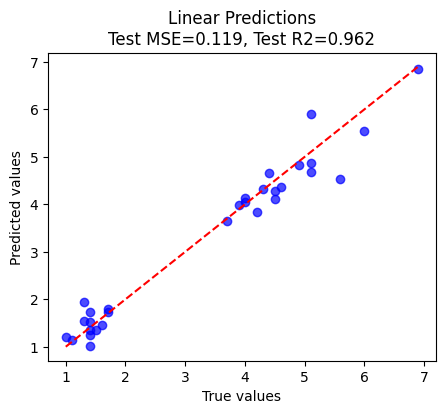

The best model for Ridge: Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('regressor', Ridge(alpha=0.01))])


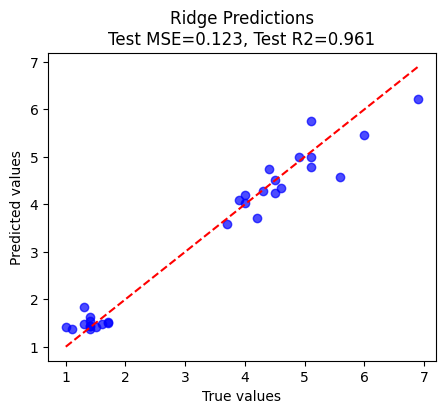

The best model for Lasso: Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(degree=4)),
                ('scaler', StandardScaler()),
                ('regressor', Lasso(alpha=0.001, max_iter=100000))])


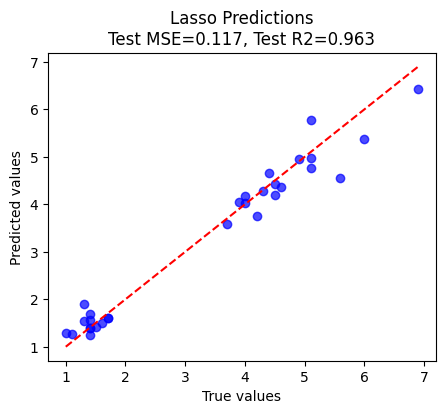

The best model for ElasticNet: Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(degree=4)),
                ('scaler', StandardScaler()),
                ('regressor',
                 ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=100000))])


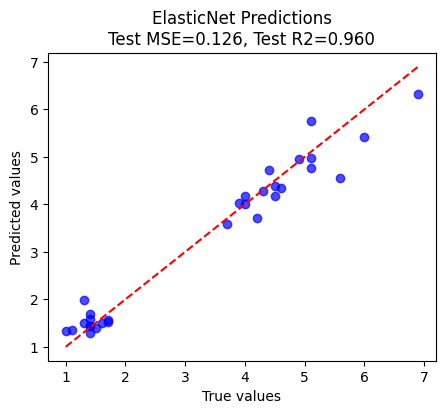

The best model for SVR: Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()), ('regressor', SVR(C=10))])


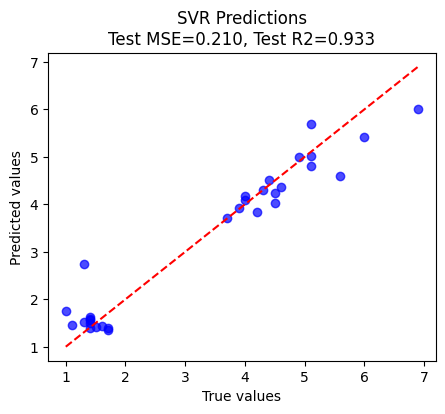

The best model for DecisionTree: Pipeline(steps=[('imputer', SimpleImputer()),
                ('regressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=4,
                                       random_state=412))])


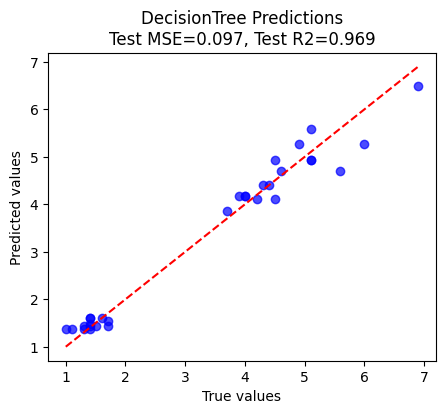

The best model for RandomForest: Pipeline(steps=[('imputer', SimpleImputer()),
                ('regressor',
                 RandomForestRegressor(max_depth=5, random_state=412))])


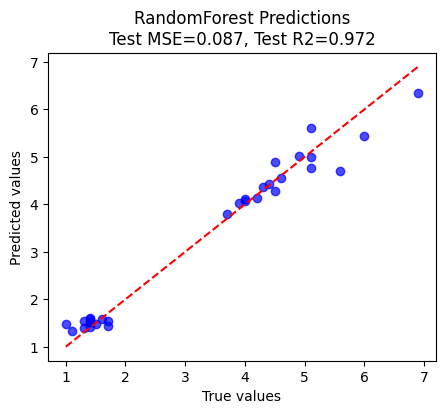

,Model,Best Params,CV R2,Test R2,R2 Diff (CV-Test),Test MSE
0,Linear,{'poly__degree': 2},0.970667,0.962299,0.008368,0.118557
1,Ridge,"{'poly__degree': 3, 'regressor__alpha': 0.01}",0.977993,0.961028,0.016965,0.122555
2,Lasso,"{'poly__degree': 4, 'regressor__alpha': 0.001}",0.976709,0.962853,0.013856,0.116815
3,ElasticNet,"{'poly__degree': 4, 'regressor__alpha': 0.001,...",0.977638,0.960079,0.017558,0.125537
4,SVR,"{'poly__degree': 1, 'regressor__C': 10, 'regre...",0.971324,0.933307,0.038017,0.209726
5,DecisionTree,"{'regressor__max_depth': 5, 'regressor__min_sa...",0.963635,0.969236,-0.005601,0.096743
6,RandomForest,"{'regressor__max_depth': 5, 'regressor__min_sa...",0.944265,0.972333,-0.028068,0.087003


In [79]:
# === 3. Run evaluation ===

evaluate_models(
    X_train, y_train, X_test, y_test,
    models_and_params=models_and_params,
    cv=5,
    plot=True
    )